In [0]:
import xgboost as xgb
import pandas as pd
# from sklearn import preprocessing, pipeline, metrics, grid_search, cross_validation
from sklearn import preprocessing, pipeline, metrics
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_validate, cross_val_score
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error

from scipy import sparse
%matplotlib inline

grid_search: GridSearchCV \\
cross_validation: cross_validate

In [0]:
def log_mae(labels,preds,lift=200):
    return mean_absolute_error(np.exp(labels)-lift, np.exp(preds)-lift)

def logregobj(labels, preds):
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 


log_mae_scorer = metrics.make_scorer(log_mae, greater_is_better = False)

def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
    ##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = log_mae_scorer,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("params:\n")
    print(model.cv_results_.__getitem__('params'))
    print("mean test scores:\n")
    print(model.cv_results_.__getitem__('mean_test_score'))
    print("std test scores:\n")
    print(model.cv_results_.__getitem__('std_test_score'))
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    # print("Scores:", model.grid_scores_)
    print("**********************************************")
    
    return model

def xg_eval_mae(yhat, dtrain, lift=200):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-lift, np.exp(yhat)-lift)

def xgb_logregobj(preds, dtrain):
    con = 2
    labels = dtrain.get_label()
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess


def search_model_mae (train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                          param_grid = param_grid,
                          scoring    = 'neg_mean_absolute_error',
                          verbose    = 10,
                          n_jobs  = n_jobs,
                          iid        = True,
                          refit    = refit,
                          cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    # print("Scores:", model.grid_scores_)
    return model

## Load data

In [0]:
# from google.colab import drive
# drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# !cp -r /content/drive/My\ Drive/Kaggle_Allstate/data/train.csv /home/

In [0]:
# !cp -r /content/drive/My\ Drive/Kaggle_Allstate/data/test.csv /home/

In [0]:
# Load data
start = time.time() 
train_data = pd.read_csv('/home/train.csv')
train_size=train_data.shape[0]
print ("Loading train data finished in %0.3fs" % (time.time() - start))        

test_data = pd.read_csv('/home/test.csv')
print ("Loading test data finished in %0.3fs" % (time.time() - start))

Loading train data finished in 3.302s
Loading test data finished in 5.206s


In [0]:
train_data.head(5)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


## Merge train and test

In [0]:
full_data=pd.concat([train_data
                       ,test_data])
del( train_data, test_data)
print ("Full Data set created.")

Full Data set created.


## Group features

In [0]:
data_types = full_data.dtypes  
cat_cols = list(data_types[data_types=='object'].index)
num_cols = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)

id_col = 'id'
target_col = 'loss'
num_cols.remove('id')
num_cols.remove('loss')

print ("Categorical features:", cat_cols)
print ( "Numerica features:", num_cols)
print ( "ID: %s, target: %s" %( id_col, target_col))

Categorical features: ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat1

In [0]:
LBL = preprocessing.LabelEncoder()
start=time.time()
for cat_col in cat_cols:
#     print ("Factorize feature %s" % (cat))
    full_data[cat_col] = LBL.fit_transform(full_data[cat_col])
print ('Label enconding finished in %f seconds' % (time.time()-start))

Label enconding finished in 18.787762 seconds


In [0]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
full_data_sparse=OHE.fit_transform(full_data[cat_cols])
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))

print (full_data_sparse.shape)

## it should be (313864, 1176)

One-hot-encoding finished in 2.965760 seconds
(313864, 1176)


In [0]:
from scipy.stats import skew, boxcox
skewed_cols = full_data[num_cols].apply(lambda x: skew(x.dropna()))
print (skewed_cols.sort_values())

cont2    -0.311146
cont3    -0.007023
cont14    0.250673
cont11    0.281139
cont12    0.291997
cont10    0.352116
cont13    0.376138
cont4     0.417559
cont6     0.458413
cont1     0.513205
cont8     0.673237
cont5     0.679610
cont7     0.825889
cont9     1.067247
dtype: float64


In [0]:
skewed_cols = skewed_cols[skewed_cols > 0.25].index.values
for skewed_col in skewed_cols:
    full_data[skewed_col], lam = boxcox(full_data[skewed_col] + 1)

In [0]:
SSL = preprocessing.StandardScaler()
# for num_col in num_cols:
#     full_data[num_col] = full_data[num_col].values.reshape(-1, 1)
#     full_data[num_col] = SSL.fit_transform(full_data[num_col])

full_data[num_cols] = SSL.fit_transform(full_data[num_cols])

In [0]:
from scipy import sparse
full_data_sparse = sparse.hstack((full_data_sparse,full_data[num_cols])).tocsr()
print (full_data_sparse.shape)

(313864, 1190)


In [0]:
shift = 200
full_cols = cat_cols + num_cols
train_x = full_data_sparse[:train_size]
test_x = full_data_sparse[train_size:]
train_y = np.log(full_data[:train_size].loss.values + 200)
ID = full_data.id[:train_size].values

In [0]:
# # Initialize data
# lift = 200

# full_cols = num_cols + cat_cols
# train_x = full_data[full_cols][:train_size].values
# test_x = full_data[full_cols][train_size:].values
# train_y = np.log(full_data[:train_size].loss.values + lift)
# ID = full_data.id[:train_size].values

In [0]:
print(train_x.shape)
print(test_x.shape)

(188318, 1190)
(125546, 1190)


## gridresearch model

In [0]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [0]:
# time consuming, use gpu to tune
param_grid = {'objective':[logregobj],
              'learning_rate':[0.01, 0.02, 0.04, 0.06, 0.08],
              'n_estimators':[1500],
              'max_depth': [9],
              'min_child_weight':[50],
              'subsample': [0.78],
              'colsample_bytree':[0.67],
              'gamma':[0.9],
              'nthread': [-1],
              'seed' : [1234]}

model = search_model(train_x,
                     train_y,
                     xgb.XGBRegressor(),
                     param_grid,
                     n_jobs = 1,
                     cv = 4,
                     refit = True)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:51:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78, score=-1136.103, total= 9.8min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.8min remaining:    0.0s


[01:01:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78, score=-1138.455, total= 9.5min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 19.3min remaining:    0.0s


[01:10:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78, score=-1136.343, total= 9.3min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 28.6min remaining:    0.0s


[01:20:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78, score=-1134.285, total= 9.3min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 37.9min remaining:    0.0s


[01:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78, score=-1138.003, total= 9.2min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 47.1min remaining:    0.0s


[01:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78, score=-1140.889, total= 9.2min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 56.2min remaining:    0.0s


[01:47:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78, score=-1139.231, total= 9.2min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 65.4min remaining:    0.0s


[01:56:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78, score=-1136.665, total= 9.4min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.06, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 74.8min remaining:    0.0s


[02:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.06, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78, score=-1139.839, total= 9.2min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.06, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 84.0min remaining:    0.0s


[02:15:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.06, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78, score=-1144.969, total= 9.2min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.06, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78 
[02:24:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.06, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f7626c23f28>, seed=1234, subsample=0.78, score=-1143.111, total= 9.5min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.06, max_depth=9, min_chi

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 150.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[03:22:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
params:

[{'colsample_bytree': 0.67, 'gamma': 0.9, 'learning_rate': 0.02, 'max_depth': 9, 'min_child_weight': 50, 'n_estimators': 1500, 'nthread': -1, 'objective': <function logregobj at 0x7f7626c23f28>, 'seed': 1234, 'subsample': 0.78}, {'colsample_bytree': 0.67, 'gamma': 0.9, 'learning_rate': 0.04, 'max_depth': 9, 'min_child_weight': 50, 'n_estimators': 1500, 'nthread': -1, 'objective': <function logregobj at 0x7f7626c23f28>, 'seed': 1234, 'subsample': 0.78}, {'colsample_bytree': 0.67, 'gamma': 0.9, 'learning_rate': 0.06, 'max_depth': 9, 'min_child_weight': 50, 'n_estimators': 1500, 'nthread': -1, 'objective': <function logregobj at 0x7f7626c23f28>, 'seed': 1234, 'subsample': 0.78}, {'colsample_bytree': 0.67, 'gamma': 0.9, 'learning_rate': 0.08, 'max_depth': 9, 'min_child_weight': 50, 'n_estimators': 1500, 'nthread': -1, 'objective': <function logregobj at 0x

AttributeError: ignored

In [0]:

# here just an example, please use the optimal parameters from last gridsearch cell
rgr = xgb.XGBRegressor(seed = 1234, 
                       learning_rate = 0.02, # smaller, better results, more time
                       n_estimators = 1500, # Number of boosted trees to fit. 
                       max_depth=9, # the maximum depth of a tree
                       min_child_weight=50,
                       colsample_bytree=0.67, # the fraction of columns to be randomly samples for each tree
                       subsample=0.78, # the fraction of observations to be randomly samples for each tree
                       gamma=0.9, # Minimum loss reduction required to make a further partition on a leaf node of the tree, 
                       # the larger, the more conservative 
                       nthread = -1, # Number of parallel threads used to run xgboost.
                       silent = False # Whether to print messages while running boosting.
                      )
rgr.fit(train_x, train_y)

[00:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.67, gamma=0.9,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=9, min_child_weight=50, missing=None, n_estimators=1500,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
             silent=False, subsample=0.78, verbosity=1)

In [0]:
pred_y = np.exp(rgr.predict(test_x)) - 200

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y
results.to_csv("/home/sub.csv", index=False)
print ("Submission created.")

Submission created.


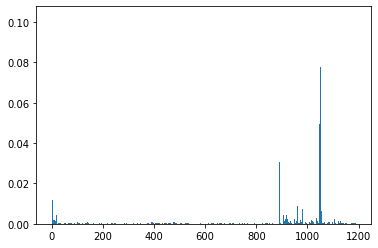

In [0]:
plt.bar(range(len(rgr.feature_importances_)), rgr.feature_importances_)
plt.show()

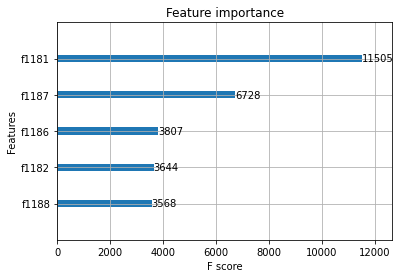

In [0]:
xgb.plot_importance(rgr,max_num_features=5,importance_type='weight')

In [0]:
np.argsort(rgr.feature_importances_)

array([ 594,  467,  471, ..., 1047, 1051, 1053])

## Parameter tuning
### XGBoost manual greedy tuning 

xgb max_depth must be >=0 


In [0]:
from sklearn.model_selection import KFold,StratifiedKFold
import copy
kfolds = 5
random_state = 42

# skf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=random_state)
skf = KFold(n_splits=kfolds, random_state=1234)
skf_ids = list(skf.split(train_y))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


lgb vs xgb:
bagging_freq = Not have this feature \\
num_leaves = max_leaves \\
max_depth = max_depth \\
min_gain_to_split = gamma \\
feature_fraction = colsample_bytree \\
bagging_fraction = subsample \\
min_sum_hessian_in_leaf = min_child_weight \\
lambda_l2 = lambda \\
lambda_l1 = alpha \\

In [0]:
default_xgb_params = {}
default_xgb_params["learning_rate"] = 0.05
default_xgb_params["metrics"] = 'rmse'
default_xgb_params["subsample"] = 1
default_xgb_params["seed"] = 1234
default_xgb_params["objective"] = 'reg:squarederror'

params_xgb_space = {}
params_xgb_space['max_leaves'] = [3, 7, 15, 31, 63, 127, 255] # the performance of =3 is equalt to others 
params_xgb_space['max_depth'] = [3 ,4 ,5 ,6 ,7 ,8] 
params_xgb_space['gamma'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_xgb_space['colsample_bytree'] = [0.1, 0.3, 0.5, 0.7, 0.9]
params_xgb_space['subsample'] = [0.2, 0.4, 0.6, 0.8, 1]
params_xgb_space['min_child_weight'] = [1, 5, 10, 30, 100]
params_xgb_space['lambda'] = [0, 0.01, 0.1, 1, 10, 100]
params_xgb_space['alpha'] = [0, 0.01, 0.1, 1, 10, 100]
# params_xgb_space['max_leaves'] = [3]
# params_xgb_space['max_depth'] = [8] 
# params_xgb_space['gamma'] = [1]
# params_xgb_space['colsample_bytree'] = [0.1]
# params_xgb_space['subsample'] = [1]
# params_xgb_space['min_child_weight'] = [100]
# params_xgb_space['lambda'] = [100]
# params_xgb_space['alpha'] = [0, 0.01, 0.1, 1, 10, 100]

In [0]:
greater_is_better = False

best_xgb_params = copy.copy(default_xgb_params)

for p in params_xgb_space:
    print ("\n Tuning parameter %s in %s" % (p, params_xgb_space[p]))

    params = best_xgb_params
    scores = []    
    for v in params_xgb_space[p]:
        print ('\n    %s: %s' % (p, v), end="\n")
        params[p] = v
        xgb_cv = xgb.cv(params,
                        xgb.DMatrix(train_x,
                                    label=train_y
                                    ),
                        num_boost_round=100000,
                        nfold=kfolds,
                        folds=list(skf.split(train_y)),
                        stratified=False,
                        early_stopping_rounds=50,
                        verbose_eval=500)

        best_xgb_score = min(xgb_cv['test-rmse-mean'])
        best_xgb_iteration = len(xgb_cv['test-rmse-mean'])
        print (', best_score: %f, best_iteration: %d' % (best_xgb_score, best_xgb_iteration))
        scores.append([v, best_xgb_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_xgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('\n Best manually tuned parameters:', best_xgb_params)


 Tuning parameter alpha in [0, 0.01, 0.1, 1, 10, 100]

    alpha: 0
[0]	train-rmse:6.97191+0.000379767	test-rmse:6.97192+0.00170671
[500]	train-rmse:0.454982+0.000391616	test-rmse:0.479481+0.00195369
[1000]	train-rmse:0.442383+0.000359705	test-rmse:0.478398+0.00196716
, best_score: 0.478335, best_iteration: 1070

    alpha: 0.01
[0]	train-rmse:6.97191+0.000379767	test-rmse:6.97192+0.00170693
[500]	train-rmse:0.454993+0.000481595	test-rmse:0.479482+0.00198249
[1000]	train-rmse:0.442441+0.000496072	test-rmse:0.478491+0.00209966
, best_score: 0.478402, best_iteration: 1135

    alpha: 0.1
[0]	train-rmse:6.97191+0.000379977	test-rmse:6.97192+0.00170674
[500]	train-rmse:0.454785+0.000298783	test-rmse:0.479572+0.00204853
[1000]	train-rmse:0.441658+0.000402947	test-rmse:0.478523+0.00211454
, best_score: 0.478359, best_iteration: 1383

    alpha: 1
[0]	train-rmse:6.97192+0.000379352	test-rmse:6.97194+0.00171107
[500]	train-rmse:0.455127+0.000469172	test-rmse:0.479181+0.00186617
[1000]	train-r

In [0]:
best_xgb_params = copy.copy(default_xgb_params)
# filled up with the best tuned parameters from last cell
best_xgb_params['max_leaves'] = 3
best_xgb_params['max_depth'] = 8
best_xgb_params['gamma'] = 1
best_xgb_params['colsample_bytree'] = 0.1
best_xgb_params['subsample'] = 1
best_xgb_params['min_child_weight'] = 100
best_xgb_params['lambda'] = 100
best_xgb_params['alpha'] = 10

In [0]:
print ('\n Best manually tuned parameters:', best_xgb_params)
# Best manually tuned parameters: {'learning_rate': 0.05, 'metrics': 'rmse', 'subsample': 1, 
# 'seed': 1234, 'objective': 'reg:squarederror', 'alpha': 10, 'max_leaves': 3, 
# 'max_depth': 8, 'gamma': 1, 'colsample_bytree': 0.1, 'min_child_weight': 100, 'lambda': 100}


 Best manually tuned parameters: {'learning_rate': 0.05, 'metrics': 'rmse', 'subsample': 1, 'seed': 1234, 'objective': 'reg:squarederror', 'max_leaves': 3, 'max_depth': 8, 'gamma': 1, 'colsample_bytree': 0.1, 'min_child_weight': 100, 'lambda': 100, 'alpha': 10}


## Automated tuning

We will be using a package BayesianOptimization for automated tuning. Results from manual tuning can be used to further narrow the space that needs to be searched from for better performance.

In [0]:
!pip install bayesian-optimization

In [0]:
from bayes_opt import BayesianOptimization

lgb vs xgb:
bagging_freq = Not have this feature \\
num_leaves = max_leaves \\
max_depth = max_depth \\
min_gain_to_split = gamma \\
feature_fraction = colsample_bytree \\
bagging_fraction = subsample \\
min_sum_hessian_in_leaf = min_child_weight \\
lambda_l2 = lambda \\
lambda_l1 = alpha \\

In [0]:
def xgb_evaluate(
    max_leaves,
    max_depth,
    min_child_weight,
    gamma,
    colsample_bytree,
    subsample,
    lambda_1,
    alpha
):
    params = dict()
    params['objective'] = 'reg:squarederror'
    params['learning_rate'] = 0.05
    params['seed'] = 1234
    params['max_leaves'] = int(max_leaves)
    params['max_depth'] = int(max_depth)
    params['min_child_weight'] = int(min_child_weight)
    params['gamma'] = gamma
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['lambda'] = lambda_1
    params['alpha'] = alpha
    params["metric"] = 'rmse'

    xgb_cv = xgb.cv(params,
                xgb.DMatrix(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=kfolds,
                folds=list(skf.split(train_y)),
                stratified=False,
                early_stopping_rounds=50,
                verbose_eval=500)

    best_xgb_score = min(xgb_cv['test-rmse-mean'])
    best_xgb_iteration = len(xgb_cv['test-rmse-mean'])
    print(', best_score: %f, best_iteration: %d' %
          (best_xgb_score, best_xgb_iteration))

    return -best_xgb_score

In [0]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

xgb_BO = BayesianOptimization(xgb_evaluate,
                              {
                                  'max_leaves': (7, 31),
                                  'max_depth': (7, 31),
                                  'min_child_weight': (0, 2),
                                  'gamma': (0, 5),
                                  'colsample_bytree': (0.3, 0.6),
                                  'subsample': (0.9, 1),
                                  'lambda_1': (0, 1),
                                  'alpha': (0, 1)
                              }
                              )

logger = JSONLogger(path="/content/drive/My Drive/Kaggle_Allstate/data/logs.json")
xgb_BO.subscribe(Events.OPTIMIZATION_STEP, logger)

In [0]:
xgb_BO.maximize(init_points=5, n_iter=40) 
# in the competition, we should use more than 25, below we use 6 points as example. 
# xgb_BO.maximize(init_points=3, n_iter=3)

[0]	train-rmse:6.97192+0.000373142	test-rmse:6.97193+0.00168466
[500]	train-rmse:0.459881+0.000479221	test-rmse:0.478169+0.00199449
[1000]	train-rmse:0.456016+0.000483969	test-rmse:0.477194+0.00201929
[1500]	train-rmse:0.453914+0.000547095	test-rmse:0.476853+0.00204023
[2000]	train-rmse:0.452427+0.000574524	test-rmse:0.476655+0.00203132
[2500]	train-rmse:0.45127+0.000549957	test-rmse:0.476498+0.00201735
[3000]	train-rmse:0.450265+0.000544427	test-rmse:0.476419+0.00203634
[3500]	train-rmse:0.449402+0.000590384	test-rmse:0.476354+0.00203511
, best_score: 0.476316, best_iteration: 3874
[0]	train-rmse:6.9717+0.000378212	test-rmse:6.97172+0.00169827
[500]	train-rmse:0.395547+0.000627834	test-rmse:0.476584+0.00182212
, best_score: 0.476472, best_iteration: 784
[0]	train-rmse:6.97214+0.000387931	test-rmse:6.97216+0.00161003
[500]	train-rmse:0.381255+0.00066667	test-rmse:0.476276+0.00221044
, best_score: 0.476253, best_iteration: 548
[0]	train-rmse:6.97177+0.000375456	test-rmse:6.97178+0.00169

In [0]:
xgb_BO.res

[{'params': {'alpha': 0.05086376980654295,
   'colsample_bytree': 0.5033744688160208,
   'gamma': 2.6181622157861733,
   'lambda_1': 0.7397577084815677,
   'max_depth': 8.980030164189422,
   'max_leaves': 7.919551599788012,
   'min_child_weight': 0.14315591674782358,
   'subsample': 0.9051490453280847},
  'target': -0.47631560000000006},
 {'params': {'alpha': 0.09079001272675025,
   'colsample_bytree': 0.5866722945625281,
   'gamma': 1.6369095054960214,
   'lambda_1': 0.23024360375487152,
   'max_depth': 16.75553362632672,
   'max_leaves': 9.670825007221119,
   'min_child_weight': 1.3504049943390304,
   'subsample': 0.9799986550908285},
  'target': -0.4764724},
 {'params': {'alpha': 0.13689947520785584,
   'colsample_bytree': 0.355130661246054,
   'gamma': 1.453223371438881,
   'lambda_1': 0.7994357770097028,
   'max_depth': 21.77486770833211,
   'max_leaves': 18.567271497068546,
   'min_child_weight': 0.403000984901696,
   'subsample': 0.9982695479454914},
  'target': -0.4762534000000

In [0]:
xgb_BO_scores = pd.DataFrame()
for dic in xgb_BO.res:
  param = dic['params']
  param = pd.DataFrame([param])
  xgb_BO_scores = pd.concat([xgb_BO_scores, param], ignore_index=True)

xgb_BO_scores

,alpha,colsample_bytree,gamma,lambda_1,max_depth,max_leaves,min_child_weight,subsample
0,0.050864,0.503374,2.618162,0.739758,8.980030,7.919552,0.143156,0.905149
1,0.090790,0.586672,1.636910,0.230244,16.755534,9.670825,1.350405,0.979999
2,0.136899,0.355131,1.453223,0.799436,21.774868,18.567271,0.403001,0.998270
3,0.816028,0.550222,2.589284,0.296166,30.972090,30.836889,1.761544,0.971608
4,0.193766,0.338236,2.932123,0.775578,30.953849,30.903633,0.584461,0.997987
5,0.436346,0.428000,0.212483,0.892537,7.317753,30.768914,1.935705,0.937101


In [0]:
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res)['target']
xgb_BO_scores.head()

,alpha,colsample_bytree,gamma,lambda_1,max_depth,max_leaves,min_child_weight,subsample,score
0,0.050864,0.503374,2.618162,0.739758,8.980030,7.919552,0.143156,0.905149,-0.476316
1,0.090790,0.586672,1.636910,0.230244,16.755534,9.670825,1.350405,0.979999,-0.476472
2,0.136899,0.355131,1.453223,0.799436,21.774868,18.567271,0.403001,0.998270,-0.476253
3,0.816028,0.550222,2.589284,0.296166,30.972090,30.836889,1.761544,0.971608,-0.475094
4,0.193766,0.338236,2.932123,0.775578,30.953849,30.903633,0.584461,0.997987,-0.475126


In [0]:
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head()

,alpha,colsample_bytree,gamma,lambda_1,max_depth,max_leaves,min_child_weight,subsample,score
3,0.816028,0.550222,2.589284,0.296166,30.972090,30.836889,1.761544,0.971608,-0.475094
4,0.193766,0.338236,2.932123,0.775578,30.953849,30.903633,0.584461,0.997987,-0.475126
2,0.136899,0.355131,1.453223,0.799436,21.774868,18.567271,0.403001,0.998270,-0.476253
0,0.050864,0.503374,2.618162,0.739758,8.980030,7.919552,0.143156,0.905149,-0.476316
1,0.090790,0.586672,1.636910,0.230244,16.755534,9.670825,1.350405,0.979999,-0.476472


In [0]:
xgb_BO_scores.to_csv("/content/drive/My Drive/Kaggle_Allstate/data/tuned_xgb_parameters.csv", index=False)

In [0]:
xgb_BO_scores = pd.read_csv("/content/drive/My Drive/Kaggle_Allstate/data/tuned_xgb_parameters.csv")
xgb_BO_scores.head()

,alpha,colsample_bytree,gamma,lambda_1,max_depth,max_leaves,min_child_weight,subsample,score
0,0.816028,0.550222,2.589284,0.296166,30.972090,30.836889,1.761544,0.971608,-0.475094
1,0.193766,0.338236,2.932123,0.775578,30.953849,30.903633,0.584461,0.997987,-0.475126
2,0.136899,0.355131,1.453223,0.799436,21.774868,18.567271,0.403001,0.998270,-0.476253
3,0.050864,0.503374,2.618162,0.739758,8.980030,7.919552,0.143156,0.905149,-0.476316
4,0.090790,0.586672,1.636910,0.230244,16.755534,9.670825,1.350405,0.979999,-0.476472


### Retrain the model with smaller learning rate 

lgb vs xgb:
bagging_freq = Not have this feature \\
num_leaves = max_leaves \\
max_depth = max_depth \\
min_gain_to_split = gamma \\
feature_fraction = colsample_bytree \\
bagging_fraction = subsample \\
min_sum_hessian_in_leaf = min_child_weight \\
lambda_l2 = lambda \\
lambda_l1 = alpha \\

In [0]:
params = xgb_BO_scores.iloc[0].to_dict()
best_auto_xgb_params = dict()
best_auto_xgb_params['objective'] = 'reg:squarederror'
best_auto_xgb_params["metric"] = 'rmse'
best_auto_xgb_params['learning_rate'] = 0.01 # Smaller learning rate
best_auto_xgb_params['max_leaves'] = int(params['max_leaves'])    
best_auto_xgb_params['max_depth'] = int(params['max_depth'])    
best_auto_xgb_params['min_child_weight'] = int(params['min_child_weight'])
best_auto_xgb_params['gamma'] = params['gamma']     
best_auto_xgb_params['colsample_bytree'] = params['colsample_bytree']
best_auto_xgb_params['subsample'] = params['subsample']
best_auto_xgb_params['lambda'] = params['lambda_1']
best_auto_xgb_params['alpha'] = params['alpha']
best_auto_xgb_params['seed'] = 1234


print (best_auto_xgb_params)

xgb_cv = xgb.cv(best_auto_xgb_params,
            xgb.DMatrix(train_x,
                        label=train_y
                        ),
            num_boost_round=100000,
            nfold=kfolds,
            folds=list(skf.split(train_y)),
            stratified=False,
            early_stopping_rounds=50,
            verbose_eval=500)

best_xgb_score = min(xgb_cv['test-rmse-mean'])
best_xgb_iteration = len(xgb_cv['test-rmse-mean'])
print (', best_score: %f, best_iteration: %d' % (best_xgb_score, best_xgb_iteration))

{'objective': 'reg:squarederror', 'metric': 'rmse', 'learning_rate': 0.01, 'max_leaves': 30, 'max_depth': 30, 'min_child_weight': 1, 'gamma': 2.589283905724397, 'colsample_bytree': 0.550221504424711, 'subsample': 0.9716080823311943, 'lambda': 0.2961662273373261, 'alpha': 0.8160280457593297, 'seed': 1234}
[0]	train-rmse:7.26347+0.000394666	test-rmse:7.26347+0.00161554
[500]	train-rmse:0.454827+0.000438066	test-rmse:0.483081+0.00207937
[1000]	train-rmse:0.437947+0.000528251	test-rmse:0.475721+0.0020776
[1500]	train-rmse:0.433034+0.000425967	test-rmse:0.474796+0.00212813
[2000]	train-rmse:0.429989+0.000359508	test-rmse:0.474426+0.00214303
[2500]	train-rmse:0.427732+0.00031817	test-rmse:0.47424+0.00215785
[3000]	train-rmse:0.425936+0.000326178	test-rmse:0.474114+0.00215574
[3500]	train-rmse:0.424409+0.000281457	test-rmse:0.474053+0.00217526
[4000]	train-rmse:0.423086+0.000291358	test-rmse:0.474008+0.0021805


## XGBosst blending function 

1. KFold.split()返回的是(train_idx, test_idx)，在旧版本中KFold()返回的是(train_idx, test_idx)


In [0]:
from sklearn.model_selection import StratifiedKFold, KFold 
import copy

In [0]:
def xgb_blend(xgb_params, train_x, train_y, test_x, kfolds, early_stopping_rounds=0, train_y_dummy=None):
    """
    estimator: parameters 
    """
    print(f"Blend {len(xgb_params)} estimators for {kfolds} folds")
    skf = KFold(n_splits=kfolds, random_state=1234)
    skf_ids = list(skf.split(train_y))

    train_blend_x = np.zeros((train_x.shape[0], len(xgb_params)))
    test_blend_x = np.zeros((test_x.shape[0], len(xgb_params)))
    blend_scores = np.zeros ((kfolds,len(xgb_params)))
    best_rounds = np.zeros ((kfolds,len(xgb_params)))

    print("Start stacking")

    for j, est in enumerate(xgb_params):
        print("Stacking model", j+1, est)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(skf_ids):
            start = time.time()
            print (f"Model {j+1} fold {i+1}")
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            print(i, est)

            if early_stopping_rounds == 0: 
                #without early stoping
                num_boost_round = copy.deepcopy(params['num_boost_round'])
                model = xgb.train(params, 
                                  xgb.DMatrix(train_x_fold, 
                                              train_y_fold
                                              ),
                                  num_boost_round=num_boost_round,
                                  verbose_eval=500
                                  )
                val_y_predict_fold = model.predict(xgb.DMatrix(val_x_fold))
                socre = log_mae(val_y_fold, val_y_predict_fold, 200)
                print(f"Score for Model {j+1} fold {i+1}: {score}")
                blend_scores[i, j] = score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(xgb.DMatrix(test_x))
                print(f"Model {j+1} fold {i+1} finished in {time.time()-start} seconds.")
            else:
                valid_data = xgb.DMatrix(val_x_fold, val_y_fold)
                model = xgb.train(params,
                                  xgb.DMatrix(train_x_fold,
                                              train_y_fold
                                              ),
                                  evals=[(valid_data, 'valid')], 
                                  num_boost_round=10000000,
                                  early_stopping_rounds=early_stopping_rounds, 
                                  verbose_eval=500)
                best_iteration = model.best_iteration
                best_ntree_limit = model.best_ntree_limit
                best_rounds[i, j] = best_iteration
                print(f"best iteration: {best_iteration}")
                print(f"best score: {model.best_score}")
                val_y_predict_fold = model.predict(xgb.DMatrix(val_x_fold), ntree_limit=best_ntree_limit)
                score = log_mae(val_y_fold, val_y_predict_fold, 200)
                print(f"Score for Model {j+1} fold {i+1}: {score}")
                blend_scores[i, j] = score 
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(xgb.DMatrix(test_x), ntree_limit=best_ntree_limit)
                print(f"Model {j+1} fold {i+1} finished in {time.time()-start}")

        test_blend_x[:, j]= test_blend_x_j / kfolds
        print(f"Score for model {j+1} is {np.mean(blend_scores[:, j])}")
    print(f"Socre for blended models is {np.mean(blend_scores)}")
    return train_blend_x, test_blend_x, blend_scores

### Select top 4 XGBoost models 

lgb vs xgb:
bagging_freq = Not have this feature \\
num_leaves = max_leaves \\
max_depth = max_depth \\
min_gain_to_split = gamma \\
feature_fraction = colsample_bytree \\
bagging_fraction = subsample \\
min_sum_hessian_in_leaf = min_child_weight \\
lambda_l2 = lambda \\
lambda_l1 = alpha \\

In [0]:
xgb_params = []
## Top 5 auto-tuned parameters
for i in range(4):
    params=dict()
    params['max_leaves'] = int(xgb_BO_scores['max_leaves'][i])
    params['max_depth'] = int(xgb_BO_scores['max_depth'][i])
    params['min_child_weight'] = int(xgb_BO_scores['min_child_weight'][i])
    params['gamma'] = xgb_BO_scores['gamma'][i]
    params['colsample_bytree'] = xgb_BO_scores['colsample_bytree'][i]
    params['subsample'] = xgb_BO_scores['subsample'][i]
    params['lambda_1'] = xgb_BO_scores['lambda_1'][i]
    params['alpha'] = int(xgb_BO_scores['alpha'][i])
    params['objective'] = 'reg:squarederror'
    params['learning_rate'] = 0.05
    params['num_boost_round']= best_xgb_iteration # use the result best_xgb_iteration from the cell Retrain the model with smaller learning rate, here use a example value 
    params['seed'] = 1234
    params["metric"] = 'rmse'
    xgb_params.append(params)

## Best manual-tuned parameters
xgb_params.append(best_xgb_params)    
print(xgb_params)

[{'max_leaves': 30, 'max_depth': 30, 'min_child_weight': 1, 'gamma': 2.589283905724397, 'colsample_bytree': 0.5502215044247111, 'subsample': 0.9716080823311944, 'lambda_1': 0.2961662273373261, 'alpha': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'num_boost_round': 2000, 'seed': 1234, 'metric': 'rmse'}, {'max_leaves': 30, 'max_depth': 30, 'min_child_weight': 0, 'gamma': 2.9321231808765176, 'colsample_bytree': 0.33823609157859263, 'subsample': 0.9979869113399464, 'lambda_1': 0.7755779092543663, 'alpha': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'num_boost_round': 2000, 'seed': 1234, 'metric': 'rmse'}, {'max_leaves': 18, 'max_depth': 21, 'min_child_weight': 0, 'gamma': 1.453223371438881, 'colsample_bytree': 0.35513066124605397, 'subsample': 0.9982695479454914, 'lambda_1': 0.7994357770097028, 'alpha': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'num_boost_round': 2000, 'seed': 1234, 'metric': 'rmse'}, {'max_leaves': 7, 'max_depth': 8, 'min_chi

In [0]:
type(train_x)

scipy.sparse.csr.csr_matrix

In [0]:
test_x.shape

(125546, 1190)

In [0]:
train_blend_x_xgb_ohe, test_blend_x_xgb_ohe, blend_scores_xgb_ohe = xgb_blend(xgb_params, train_x, train_y, test_x, 4, 1000)

Blend 5 estimators for 4 folds
Start stacking
Stacking model 1 {'max_leaves': 30, 'max_depth': 30, 'min_child_weight': 1, 'gamma': 2.589283905724397, 'colsample_bytree': 0.5502215044247111, 'subsample': 0.9716080823311944, 'lambda_1': 0.2961662273373261, 'alpha': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'num_boost_round': 2000, 'seed': 1234, 'metric': 'rmse'}
Model 1 fold 1
0 {'max_leaves': 30, 'max_depth': 30, 'min_child_weight': 1, 'gamma': 2.589283905724397, 'colsample_bytree': 0.5502215044247111, 'subsample': 0.9716080823311944, 'lambda_1': 0.2961662273373261, 'alpha': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'num_boost_round': 2000, 'seed': 1234, 'metric': 'rmse'}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0]	valid-rmse:6.96996
Will train until valid-rmse hasn't improved in 1000 rounds.
[500]	valid-rmse:0.477799
[1000]	valid-rmse:0.476925
[1500]	valid-rmse:0.476611
[2000]	valid-rmse:0.476452
[2500]	valid-rmse:0.476292
[3000]	valid-rmse:0.476198
[3500]	valid-rmse:0.476102
[4000]	valid-rmse:0.475978
[4500]	valid-rmse:0.475925
[5000]	valid-rmse:0.47588
[5500]	valid-rmse:0.475838
[6000]	valid-rmse:0.475838
[6500]	valid-rmse:0.47581
[7000]	valid-rmse:0.475792
[7500]	valid-rmse:0.475763
[8000]	valid-rmse:0.47571
[8500]	valid-rmse:0.475717
[9000]	valid-rmse:0.475734
Stopping. Best iteration:
[8056]	valid-rmse:0.475699

best iteration: 8056
best score: 0.475699
Score for Model 1 fold 1: 1138.5577464832966
Model 1 fold 1 finished in 2556.266452550888
Model 1 fold 2
1 {'max_leaves': 30, 'max_depth': 30, 'min_child_weight': 1, 'gamma': 2.589283905724397, 'colsample_bytree': 0.5502215044247111, 'subsample': 0.9716080823311944, 'lambda_1': 0.2961662273373261, 'alpha': 0, 'objective': 'reg:squarederr

In [0]:
print (np.mean(blend_scores_xgb_ohe,axis=0))
np.savetxt("/content/drive/My Drive/Kaggle_Allstate/data/train_blend_x_xgb_ohe.csv",train_blend_x_xgb_ohe, delimiter=",")
np.savetxt("/content/drive/My Drive/Kaggle_Allstate/data/test_blend_x_xgb_ohe.csv",test_blend_x_xgb_ohe, delimiter=",")

[1139.82484283 1139.82484283 1139.82484283 1139.82484283 1139.82484283]


In [0]:
blend_scores_xgb_ohe

array([[1138.55774648, 1138.55774648, 1138.55774648, 1138.55774648,
        1138.55774648],
       [1144.64372616, 1144.64372616, 1144.64372616, 1144.64372616,
        1144.64372616],
       [1138.18905375, 1138.18905375, 1138.18905375, 1138.18905375,
        1138.18905375],
       [1137.9088449 , 1137.9088449 , 1137.9088449 , 1137.9088449 ,
        1137.9088449 ]])

## LightGBM tuning 

### Manual tuning 

In [0]:
import lightgbm as lgb

In [0]:
import copy
default_lgb_params = {}
default_lgb_params["learning_rate"] = 0.05
default_lgb_params["metric"] = 'rmse'
default_lgb_params["bagging_freq"] = 1
default_lgb_params["seed"] = 1234
default_lgb_params["objective"] = "regression"

params_lgb_space = {}
params_lgb_space['num_leaves'] = [3, 7, 15, 31, 63, 127, 255]
params_lgb_space['max_depth'] = [3 ,4 ,5 ,6 ,7 ,8, -1]
params_lgb_space['min_gain_to_split'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_lgb_space['feature_fraction'] = [0.1, 0.3, 0.5, 0.7, 0.9]
params_lgb_space['bagging_fraction'] = [0.2, 0.4, 0.6, 0.8, 1]
params_lgb_space['min_sum_hessian_in_leaf'] = [1, 5, 10, 30, 100]
params_lgb_space['lambda_l2'] = [0, 0.01, 0.1, 1, 10, 100]
params_lgb_space['lambda_l1'] = [0, 0.01, 0.1, 1, 10, 100]
# params_lgb_space['objective'] = ['regression', 'regression_l1', 'poisson']



greater_is_better = False

best_lgb_params = copy.copy(default_lgb_params)

for p in params_lgb_space:
    print ("\n Tuning parameter %s in %s" % (p, params_lgb_space[p]))

    params = best_lgb_params
    scores = []    
    for v in params_lgb_space[p]:
        print ('\n    %s: %s' % (p, v), end="\n")
        params[p] = v
        lgb_cv = lgb.cv(params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=kfolds,
                folds=skf.split(train_x,train_y),
                stratified=False,
                early_stopping_rounds=50,
                verbose_eval=500)

        best_lgb_score = min(lgb_cv['rmse-mean'])
        best_lgb_iteration = len(lgb_cv['rmse-mean'])
        print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))
        scores.append([v, best_lgb_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_lgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('\n Best manually tuned parameters:', best_lgb_params)


 Tuning parameter num_leaves in [3, 7, 15, 31, 63, 127, 255]

    num_leaves: 3
[500]	cv_agg's rmse: 0.505839 + 0.00191511
[1000]	cv_agg's rmse: 0.496659 + 0.00204289
[1500]	cv_agg's rmse: 0.492759 + 0.00203624
[2000]	cv_agg's rmse: 0.490481 + 0.00207569
[2500]	cv_agg's rmse: 0.488903 + 0.00210415
[3000]	cv_agg's rmse: 0.487686 + 0.00204864
[3500]	cv_agg's rmse: 0.486779 + 0.00200334
[4000]	cv_agg's rmse: 0.486039 + 0.00203188
[4500]	cv_agg's rmse: 0.485444 + 0.00207037
[5000]	cv_agg's rmse: 0.484937 + 0.0020953
[5500]	cv_agg's rmse: 0.484493 + 0.00207589
[6000]	cv_agg's rmse: 0.484114 + 0.00208844
[6500]	cv_agg's rmse: 0.483753 + 0.00212901
[7000]	cv_agg's rmse: 0.483364 + 0.00204097
[7500]	cv_agg's rmse: 0.483133 + 0.00200727
[8000]	cv_agg's rmse: 0.482911 + 0.00201319
[8500]	cv_agg's rmse: 0.482682 + 0.00201121
[9000]	cv_agg's rmse: 0.482531 + 0.00203356
[9500]	cv_agg's rmse: 0.482406 + 0.00204363
[10000]	cv_agg's rmse: 0.482228 + 0.00200524
[10500]	cv_agg's rmse: 0.482078 + 0.0019

In [0]:
best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
best_lgb_params[p] = best_param_value
print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('\n Best manually tuned parameters:', best_lgb_params)
# Best manually tuned parameters: {'learning_rate': 0.05, 'metric': 'rmse', 
# 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'num_leaves': 127,
# 'max_depth': -1, 'min_gain_to_split': 0, 'feature_fraction': 0.3, 
# 'bagging_fraction': 1, 'min_sum_hessian_in_leaf': 100, 'lambda_l2': 0.1, 'lambda_l1': 0}

Best lambda_l1 is 0 with a score of 0.474831

 Best manually tuned parameters: {'learning_rate': 0.05, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'num_leaves': 127, 'max_depth': -1, 'min_gain_to_split': 0, 'feature_fraction': 0.3, 'bagging_fraction': 1, 'min_sum_hessian_in_leaf': 100, 'lambda_l2': 0.1, 'lambda_l1': 0}


In [0]:
best_lgb_params = {'learning_rate': 0.05, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'num_leaves': 127, 'max_depth': -1, 'min_gain_to_split': 0, 'feature_fraction': 0.3, 'bagging_fraction': 1, 'min_sum_hessian_in_leaf': 100, 'lambda_l2': 0.1, 'lambda_l1': 0}

### Automated tuning


In [0]:
def lgb_evaluate(
    num_leaves,
    max_depth,
    min_sum_hessian_in_leaf,
    min_gain_to_split,
    feature_fraction,
    bagging_fraction,
    lambda_l2,
    lambda_l1
):
    params = dict()
    params['objective'] = 'regression'
    params['learning_rate'] = 0.05
    params['seed'] = 1234
    params['num_leaves'] = int(num_leaves)
    params['max_depth'] = int(max_depth)
    params['min_sum_hessian_in_leaf'] = int(min_sum_hessian_in_leaf)
    params['min_gain_to_split'] = min_gain_to_split
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = 1
    params['lambda_l2'] = lambda_l2
    params['lambda_l1'] = lambda_l1
    params["metric"] = 'rmse'

    lgb_cv = lgb.cv(params,
                    lgb.Dataset(train_x,
                                label=train_y
                                ),
                    num_boost_round=100000,
                    nfold=kfolds,
                    folds=skf.split(train_x, train_y),
                    early_stopping_rounds=50,
                    verbose_eval=500)

    best_lgb_score = min(lgb_cv['rmse-mean'])
    best_lgb_iteration = len(lgb_cv['rmse-mean'])
    print(', best_score: %f, best_iteration: %d' %
          (best_lgb_score, best_lgb_iteration))

    return -best_lgb_score


lgb_BO = BayesianOptimization(lgb_evaluate,
                              {
                                  'num_leaves': (7, 31),
                                  'max_depth': (7, 31),
                                  'min_sum_hessian_in_leaf': (0, 2),
                                  'min_gain_to_split': (0, 5),
                                  'feature_fraction': (0.3, 0.6),
                                  'bagging_fraction': (0.9, 1),
                                  'lambda_l2': (0, 1),
                                  'lambda_l1': (0, 1)
                              }
                              )

lgb_BO.maximize(init_points=5, n_iter=40)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
, best_score: 0.483431, best_iteration: 428
|  1        | -0.4834   |  0.9261   |  0.3936   |  0.4878   |  0.5012   |  13.61    |  1.891    |  0.4009   |  19.77    |
[500]	cv_agg's rmse: 0.484975 + 0.00218251
, best_score: 0.483466, best_iteration: 845
|  2        | -0.4835   |  0.9077   |  0.5601   |  0.639    |  0.5944   |  28.85    |  0.9988   |  0.4624   |  9.263    |
, best_score: 0.486230, best_iteration: 428
|  3        | -0.4862   |  0.9453   |  0.5678   |  0.9204   |  0.6542   |  22.83    |  2.719    |  0.3478   |  11.49    |
[500]	cv_agg's rmse: 0.485547 + 0.00202264
, best_score: 0.485547, best_iteration: 465
|  4        | -0.4855   |  0.9654   |  0.3236   |  0.7185   |  0.9529   |  9.554    |  2.589    |  1.307    |  12.87    |
, best

In [0]:
# lgb_BO_scores = pd.DataFrame(lgb_BO.res['all']['params'])
# lgb_BO_scores['score'] = pd.DataFrame(lgb_BO.res['all']['values'])
# lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)

# lgb_BO_scores.to_csv("../python/tuned_lgb_parameters.csv", index=False)
# lgb_BO_scores.head()

In [0]:
lgb_BO_scores = pd.DataFrame()
for dic in lgb_BO.res:
  param = dic['params']
  param = pd.DataFrame([param])
  lgb_BO_scores = pd.concat([lgb_BO_scores, param], ignore_index=True)

lgb_BO_scores['score'] = pd.DataFrame(lgb_BO.res)['target']
lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)
lgb_BO_scores.to_csv("/content/drive/My Drive/Kaggle_Allstate/data/tuned_lgb_parameters.csv", index=False)
lgb_BO_scores.head()

,bagging_fraction,feature_fraction,lambda_l1,lambda_l2,max_depth,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,score
24,0.910978,0.327053,0.368974,0.957313,28.970349,0.011020,1.448205,30.684386,-0.476492
28,0.978161,0.395853,0.746052,0.961526,30.533542,0.011259,0.463573,30.103439,-0.476536
42,0.948743,0.370517,0.498037,0.994976,23.930208,0.005964,0.090805,30.154232,-0.476537
40,0.917562,0.382699,0.897928,0.990475,8.365717,0.018716,0.535025,30.790027,-0.476643
26,0.974626,0.307545,0.042501,0.009317,27.842715,0.012032,0.453331,30.864902,-0.476694


In [0]:
params = lgb_BO_scores.iloc[0].to_dict()
best_auto_lgb_params = dict()
best_auto_lgb_params['objective'] = 'regression'
best_auto_lgb_params["metric"] = 'rmse'
best_auto_lgb_params['learning_rate'] = 0.01 # Smaller learning rate
best_auto_lgb_params['num_leaves'] = int(params['num_leaves'])    
best_auto_lgb_params['max_depth'] = int(params['max_depth'])    
best_auto_lgb_params['min_sum_hessian_in_leaf'] = int(params['min_sum_hessian_in_leaf'])
best_auto_lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
best_auto_lgb_params['feature_fraction'] = params['feature_fraction']
best_auto_lgb_params['bagging_fraction'] = params['bagging_fraction']
best_auto_lgb_params['bagging_freq'] = 1
best_auto_lgb_params['lambda_l2'] = params['lambda_l2']
best_auto_lgb_params['lambda_l1'] = params['lambda_l1']
best_auto_lgb_params['seed'] = 1234


print (best_auto_lgb_params)


lgb_cv = lgb.cv(best_auto_lgb_params,
            lgb.Dataset(train_x,
                        label=train_y
                        ),
            num_boost_round=100000,
            nfold=kfolds,
            folds=skf.split(train_x,train_y),
            early_stopping_rounds=50,
            verbose_eval=500)

best_lgb_score = min(lgb_cv['rmse-mean'])
best_lgb_iteration = len(lgb_cv['rmse-mean'])
print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))

{'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.01, 'num_leaves': 30, 'max_depth': 28, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 0.011020449786837139, 'feature_fraction': 0.3270532900734156, 'bagging_fraction': 0.9109777545232665, 'bagging_freq': 1, 'lambda_l2': 0.9573128272463252, 'lambda_l1': 0.3689738745120329, 'seed': 1234}
[500]	cv_agg's rmse: 0.493133 + 0.00177316
[1000]	cv_agg's rmse: 0.481575 + 0.00191599
[1500]	cv_agg's rmse: 0.478809 + 0.00197259
[2000]	cv_agg's rmse: 0.477861 + 0.0020071
[2500]	cv_agg's rmse: 0.477321 + 0.00201479
[3000]	cv_agg's rmse: 0.47692 + 0.00199175
[3500]	cv_agg's rmse: 0.476625 + 0.00198271
[4000]	cv_agg's rmse: 0.476381 + 0.00198176
[4500]	cv_agg's rmse: 0.47618 + 0.00198871
[5000]	cv_agg's rmse: 0.476015 + 0.00197781
[5500]	cv_agg's rmse: 0.475884 + 0.00197172
[6000]	cv_agg's rmse: 0.47577 + 0.00196483
[6500]	cv_agg's rmse: 0.475701 + 0.00197308
[7000]	cv_agg's rmse: 0.475635 + 0.00198708
[7500]	cv_agg's rmse: 0.475591 + 

In [0]:
from sklearn.metrics import mean_squared_error

def lgb_rgr_stack(rgr_params, train_x, train_y, test_x, kfolds, early_stopping_rounds=0, train_y_dummy=None):

    skf = KFold(n_splits=kfolds,random_state=1234)
    skf_ids = list(skf.split(train_y))


    train_blend_x = np.zeros((train_x.shape[0], len(rgr_params)))
    test_blend_x = np.zeros((test_x.shape[0], len(rgr_params)))
    blend_scores = np.zeros ((kfolds,len(rgr_params)))

    print("Start stacking.")
    for j, params in enumerate(rgr_params):
        print("Stacking model",j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(skf_ids):
            start = time.time()
            print("Model %d fold %d" %(j+1,i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            print(i, params)
            
            
            if early_stopping_rounds==0:
                num_boost_round = copy.deepcopy(params['num_boost_round'])
                model = lgb.train(params,
                                    lgb.Dataset(train_x_fold, 
                                                train_y_fold
                                               ),
                                  num_boost_round=num_boost_round,
                                  verbose_eval=500
                )
                val_y_predict_fold = model.predict(val_x_fold)
                score = np.sqrt(mean_squared_error(val_y_fold,val_y_predict_fold))
                print("Score for Model %d fold %d: %f " % (j+1,i+1,score))
                blend_scores[i,j]=score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(test_x)
                print("Model %d fold %d finished in %d seconds." % (j+1,i+1, time.time()-start))
            else:
                model = lgb.train(params,
                                    lgb.Dataset(train_x_fold, 
                                                train_y_fold
                                               ),
                                  valid_sets=[lgb.Dataset(val_x_fold, 
                                                val_y_fold
                                                         )],
                                  valid_names=['valid'],
                                  num_boost_round=10000000,
                                  early_stopping_rounds = early_stopping_rounds,
                                  verbose_eval=500
                                )
                best_iteration = model.best_iteration
                print(model.best_score['valid']['rmse'])
                val_y_predict_fold = model.predict(val_x_fold, num_iteration=best_iteration)
                score = np.sqrt(mean_squared_error(val_y_fold,val_y_predict_fold))
                print("Score for Model %d fold %d: %f " % (j+1,i+1,score))
                blend_scores[i,j]=score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(test_x, num_iteration=best_iteration)
                print("Model %d fold %d finished in %d seconds." % (j+1,i+1, time.time()-start))                
                
        test_blend_x[:,j] = test_blend_x_j/kfolds
        print("Score for model %d is %f" % (j+1,np.mean(blend_scores[:,j])))
    return train_blend_x, test_blend_x, blend_scores

In [0]:
lgb_params = []
## Top 5 auto-tuned parameters
for i in range(4):
    params=dict()
    params['num_leaves'] = int(lgb_BO_scores['num_leaves'][i])
    params['max_depth'] = int(lgb_BO_scores['max_depth'][i])
    params['min_sum_hessian_in_leaf'] = int(lgb_BO_scores['min_sum_hessian_in_leaf'][i])
    params['min_gain_to_split'] = lgb_BO_scores['min_gain_to_split'][i]
    params['feature_fraction'] = lgb_BO_scores['feature_fraction'][i]
    params['bagging_fraction'] = lgb_BO_scores['bagging_fraction'][i]
    params['bagging_freq'] = 1
    params['lambda_l2'] = lgb_BO_scores['lambda_l2'][i]
    params['lambda_l1'] = int(lgb_BO_scores['lambda_l1'][i])
    params['objective'] = 'regression'
    params['learning_rate'] = 0.05
    params['num_boost_round']=best_lgb_iteration
    params['seed'] = 1234
    params["metric"] = 'rmse'
    lgb_params.append(params)

## Best manual-tuned parameters
lgb_params.append(best_lgb_params)    
print(lgb_params)

[{'num_leaves': 19, 'max_depth': 13, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 1.8911939074101998, 'feature_fraction': 0.3935702090101798, 'bagging_fraction': 0.9260923095895497, 'bagging_freq': 1, 'lambda_l2': 0.5011725532537579, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}, {'num_leaves': 9, 'max_depth': 28, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.9987831566693989, 'feature_fraction': 0.5601058341275948, 'bagging_fraction': 0.9076850501904176, 'bagging_freq': 1, 'lambda_l2': 0.5944451062263593, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}, {'num_leaves': 11, 'max_depth': 22, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 2.7187828562922918, 'feature_fraction': 0.5678090432745226, 'bagging_fraction': 0.9452547287748738, 'bagging_freq': 1, 'lambda_l2': 0.6542431114025132, 'lambda_l1': 0, 'objective': 'regre

In [0]:
train_blend_x_lgb_ohe, test_blend_x_lgb_ohe, blend_scores_lgb_ohe = lgb_rgr_stack(lgb_params, train_x, train_y, test_x, 4, early_stopping_rounds=50)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Start stacking.
Stacking model 1 {'num_leaves': 19, 'max_depth': 13, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 1.8911939074101998, 'feature_fraction': 0.3935702090101798, 'bagging_fraction': 0.9260923095895497, 'bagging_freq': 1, 'lambda_l2': 0.5011725532537579, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}
Model 1 fold 1
0 {'num_leaves': 19, 'max_depth': 13, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 1.8911939074101998, 'feature_fraction': 0.3935702090101798, 'bagging_fraction': 0.9260923095895497, 'bagging_freq': 1, 'lambda_l2': 0.5011725532537579, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[399]	valid's rmse: 0.483283
0.48328311524900386
Score for Model 1 fold 1: 0.483283 
Model 1 fold 1 finished in 14 seconds.
Model

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[438]	valid's rmse: 0.482828
0.4828275781401167
Score for Model 1 fold 2: 0.482828 
Model 1 fold 2 finished in 14 seconds.
Model 1 fold 3
2 {'num_leaves': 19, 'max_depth': 13, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 1.8911939074101998, 'feature_fraction': 0.3935702090101798, 'bagging_fraction': 0.9260923095895497, 'bagging_freq': 1, 'lambda_l2': 0.5011725532537579, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[405]	valid's rmse: 0.484792
0.48479184455217617
Score for Model 1 fold 3: 0.484792 
Model 1 fold 3 finished in 14 seconds.
Model 1 fold 4
3 {'num_leaves': 19, 'max_depth': 13, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 1.8911939074101998, 'feature_fraction': 0.3935702090101798, 'bagging_fraction': 0.9260923095895497, 'bagging_freq': 1, 'lambda_l2': 0.5011725532537579, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[379]	valid's rmse: 0.483479
0.4834790339567911
Score for Model 1 fold 4: 0.483479 
Model 1 fold 4 finished in 13 seconds.
Score for model 1 is 0.483595
Stacking model 2 {'num_leaves': 9, 'max_depth': 28, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.9987831566693989, 'feature_fraction': 0.5601058341275948, 'bagging_fraction': 0.9076850501904176, 'bagging_freq': 1, 'lambda_l2': 0.5944451062263593, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}
Model 2 fold 1
0 {'num_leaves': 9, 'max_depth': 28, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.9987831566693989, 'feature_fraction': 0.5601058341275948, 'bagging_fraction': 0.9076850501904176, 'bagging_freq': 1, 'lambda_l2': 0.5944451062263593, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'r

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[500]	valid's rmse: 0.484981
Early stopping, best iteration is:
[839]	valid's rmse: 0.483424
0.4834237561965046
Score for Model 2 fold 1: 0.483424 
Model 2 fold 1 finished in 25 seconds.
Model 2 fold 2
1 {'num_leaves': 9, 'max_depth': 28, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.9987831566693989, 'feature_fraction': 0.5601058341275948, 'bagging_fraction': 0.9076850501904176, 'bagging_freq': 1, 'lambda_l2': 0.5944451062263593, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[500]	valid's rmse: 0.484044
Early stopping, best iteration is:
[845]	valid's rmse: 0.482364
0.48236382410703044
Score for Model 2 fold 2: 0.482364 
Model 2 fold 2 finished in 25 seconds.
Model 2 fold 3
2 {'num_leaves': 9, 'max_depth': 28, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.9987831566693989, 'feature_fraction': 0.5601058341275948, 'bagging_fraction': 0.9076850501904176, 'bagging_freq': 1, 'lambda_l2': 0.5944451062263593, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[500]	valid's rmse: 0.48673
Early stopping, best iteration is:
[929]	valid's rmse: 0.484981
0.4849812257699335
Score for Model 2 fold 3: 0.484985 
Model 2 fold 3 finished in 27 seconds.
Model 2 fold 4
3 {'num_leaves': 9, 'max_depth': 28, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.9987831566693989, 'feature_fraction': 0.5601058341275948, 'bagging_fraction': 0.9076850501904176, 'bagging_freq': 1, 'lambda_l2': 0.5944451062263593, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[500]	valid's rmse: 0.485306
Early stopping, best iteration is:
[872]	valid's rmse: 0.483604
0.483603970836604
Score for Model 2 fold 4: 0.483604 
Model 2 fold 4 finished in 25 seconds.
Score for model 2 is 0.483594
Stacking model 3 {'num_leaves': 11, 'max_depth': 22, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 2.7187828562922918, 'feature_fraction': 0.5678090432745226, 'bagging_fraction': 0.9452547287748738, 'bagging_freq': 1, 'lambda_l2': 0.6542431114025132, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}
Model 3 fold 1
0 {'num_leaves': 11, 'max_depth': 22, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 2.7187828562922918, 'feature_fraction': 0.5678090432745226, 'bagging_fraction': 0.9452547287748738, 'bagging_freq': 1, 'lambda_l2': 0.6542431114025132, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 78

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[386]	valid's rmse: 0.486391
0.4863906242021359
Score for Model 3 fold 1: 0.486391 
Model 3 fold 1 finished in 14 seconds.
Model 3 fold 2
1 {'num_leaves': 11, 'max_depth': 22, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 2.7187828562922918, 'feature_fraction': 0.5678090432745226, 'bagging_fraction': 0.9452547287748738, 'bagging_freq': 1, 'lambda_l2': 0.6542431114025132, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[423]	valid's rmse: 0.485635
0.4856354514600897
Score for Model 3 fold 2: 0.485635 
Model 3 fold 2 finished in 15 seconds.
Model 3 fold 3
2 {'num_leaves': 11, 'max_depth': 22, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 2.7187828562922918, 'feature_fraction': 0.5678090432745226, 'bagging_fraction': 0.9452547287748738, 'bagging_freq': 1, 'lambda_l2': 0.6542431114025132, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[403]	valid's rmse: 0.487713
0.4877130319343863
Score for Model 3 fold 3: 0.487713 
Model 3 fold 3 finished in 15 seconds.
Model 3 fold 4
3 {'num_leaves': 11, 'max_depth': 22, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 2.7187828562922918, 'feature_fraction': 0.5678090432745226, 'bagging_fraction': 0.9452547287748738, 'bagging_freq': 1, 'lambda_l2': 0.6542431114025132, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[422]	valid's rmse: 0.486264
0.48626412074104153
Score for Model 3 fold 4: 0.486264 
Model 3 fold 4 finished in 15 seconds.
Score for model 3 is 0.486501
Stacking model 4 {'num_leaves': 12, 'max_depth': 9, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 2.5886484059601296, 'feature_fraction': 0.323572271570093, 'bagging_fraction': 0.9653709218402505, 'bagging_freq': 1, 'lambda_l2': 0.9528651763800765, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}
Model 4 fold 1
0 {'num_leaves': 12, 'max_depth': 9, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 2.5886484059601296, 'feature_fraction': 0.323572271570093, 'bagging_fraction': 0.9653709218402505, 'bagging_freq': 1, 'lambda_l2': 0.9528651763800765, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rm

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[500]	valid's rmse: 0.485474
Early stopping, best iteration is:
[456]	valid's rmse: 0.485474
0.4854740643104017
Score for Model 4 fold 1: 0.485474 
Model 4 fold 1 finished in 13 seconds.
Model 4 fold 2
1 {'num_leaves': 12, 'max_depth': 9, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 2.5886484059601296, 'feature_fraction': 0.323572271570093, 'bagging_fraction': 0.9653709218402505, 'bagging_freq': 1, 'lambda_l2': 0.9528651763800765, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[500]	valid's rmse: 0.485709
Early stopping, best iteration is:
[459]	valid's rmse: 0.485709
0.4857091216320995
Score for Model 4 fold 2: 0.485709 
Model 4 fold 2 finished in 13 seconds.
Model 4 fold 3
2 {'num_leaves': 12, 'max_depth': 9, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 2.5886484059601296, 'feature_fraction': 0.323572271570093, 'bagging_fraction': 0.9653709218402505, 'bagging_freq': 1, 'lambda_l2': 0.9528651763800765, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[418]	valid's rmse: 0.487494
0.4874938076624037
Score for Model 4 fold 3: 0.487494 
Model 4 fold 3 finished in 13 seconds.
Model 4 fold 4
3 {'num_leaves': 12, 'max_depth': 9, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 2.5886484059601296, 'feature_fraction': 0.323572271570093, 'bagging_fraction': 0.9653709218402505, 'bagging_freq': 1, 'lambda_l2': 0.9528651763800765, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 7839, 'seed': 1234, 'metric': 'rmse'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[398]	valid's rmse: 0.486387
0.48638660438075376
Score for Model 4 fold 4: 0.486387 
Model 4 fold 4 finished in 12 seconds.
Score for model 4 is 0.486266
Stacking model 5 {'learning_rate': 0.05, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'num_leaves': 127, 'max_depth': -1, 'min_gain_to_split': 0, 'feature_fraction': 0.3, 'bagging_fraction': 1, 'min_sum_hessian_in_leaf': 100, 'lambda_l2': 0.1, 'lambda_l1': 0}
Model 5 fold 1
0 {'learning_rate': 0.05, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'num_leaves': 127, 'max_depth': -1, 'min_gain_to_split': 0, 'feature_fraction': 0.3, 'bagging_fraction': 1, 'min_sum_hessian_in_leaf': 100, 'lambda_l2': 0.1, 'lambda_l1': 0}
Training until validation scores don't improve for 50 rounds.
[500]	valid's rmse: 0.474339
Early stopping, best iteration is:
[492]	valid's rmse: 0.474304
0.474303

In [0]:
print (np.mean(blend_scores_lgb_ohe,axis=0))
np.savetxt("/content/drive/My Drive/Kaggle_Allstate/data/train_blend_x_lgb_ohe.csv",train_blend_x_lgb_ohe, delimiter=",")
np.savetxt("/content/drive/My Drive/Kaggle_Allstate/data/test_blend_x_lgb_ohe.csv",test_blend_x_lgb_ohe, delimiter=",")

[0.48359543 0.48359423 0.48650081 0.4862659  0.47548528]


In [0]:
blend_scores_lgb_ohe

array([[0.48328312, 0.48342376, 0.48639062, 0.48547406, 0.4743036 ],
       [0.48282758, 0.48236437, 0.48563545, 0.48570912, 0.47538705],
       [0.48479185, 0.48498484, 0.48771303, 0.48749381, 0.47746138],
       [0.48347917, 0.48360397, 0.48626412, 0.48638661, 0.47478908]])

In [0]:
type(train_blend_x_lgb_ohe)

numpy.ndarray

## stacking

In [0]:
from sklearn.linear_model import Ridge,ElasticNet, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from numpy import genfromtxt

In [0]:
train_blend_x_xgb_ohe  = genfromtxt("/content/drive/My Drive/Kaggle_Allstate/data/train_blend_x_xgb_ohe.csv", delimiter=',')
test_blend_x_xgb_ohe  = genfromtxt("/content/drive/My Drive/Kaggle_Allstate/data/test_blend_x_xgb_ohe.csv", delimiter=',')

In [0]:
print  ("stacking.")
param_grid = {
    'alpha':[0,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,15,20,25,30,35,40,45,50,55,60,70,100]
              }

stacking.


In [0]:
model = search_model(np.hstack((train_blend_x_xgb_ohe,
                                train_blend_x_lgb_ohe,
                                ))
                                , train_y
                                , Ridge()
                                , param_grid
                                , n_jobs=1
                                , cv=4
                                , refit=True)   

print("best subsample:", model.best_params_)

Fitting 4 folds for each of 26 candidates, totalling 104 fits
[CV] alpha=0 .........................................................
[CV] ......................... alpha=0, score=-1132.545, total=   0.1s
[CV] alpha=0 .........................................................
[CV] ......................... alpha=0, score=-1196.459, total=   0.1s
[CV] alpha=0 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ......................... alpha=0, score=-1133.522, total=   0.1s
[CV] alpha=0 .........................................................
[CV] ......................... alpha=0, score=-1211.354, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ..................... alpha=1e-05, score=-1131.808, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ..................... alpha=1e-05, score=-1138.928, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ..................... alpha=1e-05, score=-1133.556, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ..................... alpha=1e-05, score=-1130.855, total=   0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s


[CV] alpha=3e-05 .....................................................
[CV] ..................... alpha=3e-05, score=-1131.808, total=   0.0s
[CV] alpha=3e-05 .....................................................
[CV] ..................... alpha=3e-05, score=-1138.928, total=   0.0s
[CV] alpha=3e-05 .....................................................
[CV] ..................... alpha=3e-05, score=-1133.556, total=   0.0s
[CV] alpha=3e-05 .....................................................
[CV] ..................... alpha=3e-05, score=-1130.855, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] .................... alpha=0.0001, score=-1131.808, total=   0.0s
[CV] alpha=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


[CV] .................... alpha=0.0001, score=-1138.928, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] .................... alpha=0.0001, score=-1133.556, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] .................... alpha=0.0001, score=-1130.855, total=   0.0s
[CV] alpha=0.0003 ....................................................
[CV] .................... alpha=0.0003, score=-1131.808, total=   0.0s
[CV] alpha=0.0003 ....................................................
[CV] .................... alpha=0.0003, score=-1138.928, total=   0.0s
[CV] alpha=0.0003 ....................................................
[CV] .................... alpha=0.0003, score=-1133.556, total=   0.0s
[CV] alpha=0.0003 ....................................................
[CV] .................... alpha=0.0003, score=-1130.855, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:    3.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [0]:
lgb_params = {'learning_rate': 0.05, 'metric': 'rmse',
              'bagging_freq': 1, 'seed': 1234, 'objective': 'regression',
              'num_leaves': 7, 'verbose': 1,
              'max_depth': 5, 'min_gain_to_split': 0,
              'feature_fraction': 0.1,
              'bagging_fraction': 0.9,
              'min_sum_hessian_in_leaf': 1,
              'lambda_l2': 0, 'lambda_l1': 0
              }

train_blend_x = np.hstack((train_blend_x_xgb_ohe,
                            train_blend_x_lgb_ohe,
                            ))

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_blend_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=kfolds,
                folds=skf.split(train_blend_x, train_y),
                early_stopping_rounds=50,
                verbose_eval=500)

best_lgb_score = min(lgb_cv['rmse-mean'])
best_lgb_iteration = len(lgb_cv['rmse-mean'])
print(', best_score: %f, best_iteration: %d' %
      (best_lgb_score, best_lgb_iteration))

ERROR! Session/line number was not unique in database. History logging moved to new session 60
[500]	cv_agg's rmse: 0.477395 + 0.00222046
[1000]	cv_agg's rmse: 0.477158 + 0.00224431
[1500]	cv_agg's rmse: 0.477019 + 0.00226803
[2000]	cv_agg's rmse: 0.476926 + 0.00227664
[2500]	cv_agg's rmse: 0.476859 + 0.00228916
, best_score: 0.476857, best_iteration: 2463


## submission 

In [0]:
pred_y_ridge = np.exp(model.predict(np.hstack((
                                test_blend_x_xgb_ohe,
                                test_blend_x_lgb_ohe,
)))) - 200

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y_ridge
results.to_csv("/content/drive/My Drive/Kaggle_Allstate/data/sub_ridge_blended.csv", index=False)
print ("Submission created.")

Submission created.


In [0]:
test_blend_x = np.hstack((test_blend_x_xgb_ohe,
                          test_blend_x_lgb_ohe,
                          ))

model = lgb.train(lgb_params,
            lgb.Dataset(train_blend_x,
                        label=train_y
                        ),
            num_boost_round=best_lgb_iteration)
preds_lgb = np.expm1(model.predict(test_blend_x))

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = preds_lgb
results.to_csv('/content/drive/My Drive/Kaggle_Allstate/data/sub_stacking_lgb.csv', index=False)
print ("Submission created.")

Submission created.


## Final submisstion 

In [0]:
pred_y = pred_y_ridge*0.5 + preds_lgb*0.5

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y
results.to_csv("/content/drive/My Drive/Kaggle_Allstate/data/sub_final.csv", index=False)
print ("Submission created.")

Submission created.
